# Classificando potencial de internamento de pacientes de uma unidade de saúde básica de de Curitiba utilizando MLP e SVM


Navegando nas bases de dados da Prefeitura Municipal de Curitiba, encontrei algumas interessantes bases de dados.

Escolhi, para este exemplo, a seguinte base:

> ### Sistema E-Saude - Perfil de atendimento de Enfermagem nas Unidades Municipais de Saúde de Curitiba
> Base de dados do sistema Informatizado "E-saúde". Este sistema viabiliza o registro dos atendimentos prestados pela Secretaria Municipal de Saúde de Curitiba em sua rede de atenção. Esta rede é composta por Unidades Básicas de Saúde, Unidades de Pronto Atendimento, Centros de Especialidades Médicas e Odontológicas, entre outros. Os dados disponibilizados para consulta referem-se ao perfil de atendimento dos profissionais de enfermagem da rede municipal de saúde.
> * Órgão responsável: Saúde
>* Responsável: Beatriz Battistella Nadas
>* Frequência de atualização: Mensal
>* Espectro temporal: Últimos 3 meses
>* Campos: Ver no dicionário de dados
>* Observações: Telefone para informações sobre a base: 41 3350-9302

Ela está disponível [no site da prefeitura](https://www.curitiba.pr.gov.br/dadosabertos/busca/?pagina=7).


## Bibliotecas necessárias

As seguintes bibliotecas serão utilizadas

In [16]:
!pip install imbalanced-learn -q
!pip install seaborn -q
!pip install scikeras -q
!pip install pandas numpy -q
!pip install matplotlib seaborn -q

Referenciandos-as

In [17]:
import pandas as pd
import numpy as np
from datetime import timedelta
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from random import random

import re

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from scikeras.wrappers import KerasClassifier


## Importando a base de dados

Foi realizado o download da base de dados diretamento do link mencionando.

O arquivo foi baixado no dia 10 de junho de 2024. Algumas alterações podem ter ocorrido após isso.

In [18]:

# Importando a base de dados
df = pd.read_csv(
    '2024-06-06_Sistema_E-Saude_Enfermagem_-_Base_de_Dados.csv', 
    encoding='cp1252', # Equivalente para ANSI para o Linux 
    header=0, 
    delimiter=';' 
    )

# Resume os dados
df.info(max_cols=50)

/tmp/ipykernel_2001668/3684684625.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1535530 entries, 0 to 1535529
Data columns (total 42 columns):
 #   Column                                        Non-Null Count    Dtype  
---  ------                                        --------------    -----  
 0   Data do Atendimento                           1535530 non-null  object 
 1   Data de Nascimento                            1535530 non-null  object 
 2   Sexo                                          1535530 non-null  object 
 3   Código do Tipo de Unidade                     1535530 non-null  int64  
 4   Tipo de Unidade                               1535530 non-null  object 
 5   Código da Unidade                             1535530 non-null  int64  
 6   Descrição da Unidade                          1535530 non-null  object 
 7   Código do Procedimento                        1535530 non-null  int64  
 8   Descrição do Procedimento                     1535530 non-null  object 
 9   Código do CBO                      

## Encontrando um problema de classificação

Por se tratar de uma base de dados de saúde, seria muito interessante se conseguissemos prever algo relacionado à saúde das pessoas.

Para tanto, pensei em um problema conceitualmente simples. Não que sua solução seja simples, mas seu entendimento é.

O objetivo será de classificar, com base na frequência de classes de doenças o paciente possui, se ele será ou não enternado. Um problema binário. Para determinar a classe de doenças que o paciente possui, será utilizada a primeira letra do código CID - Código Internacional de Doença - de cada atendimento do paciente. 

#### Delimitando o problema


In [27]:
# Seleciona as colunas
data = df[['cod_usuario', 'Código do CID', 'Data do Atendimento', 'Desencadeou Internamento']].copy()
data.columns = ['cod_usuario', 'cid', 'data_atendimento', 'desencadeou_internamento']

# Filtra apenas primeira caracter do CID
data['cid'] = data['cid'].str[:1]

# Remove sem cids
data['cid'] = data['cid'].fillna('NA')

# Convert data do atendimento
data['data_atendimento'] = pd.to_datetime(data['data_atendimento'], format='%d/%m/%Y %H:%M:%S')

# Primeiro internamento por paciente
minimos = data[data['desencadeou_internamento'] != 'Nao'].copy()
minimos = minimos.groupby('cod_usuario')['data_atendimento'].min()
minimos = pd.DataFrame(minimos)
minimos.reset_index(drop=False, names='cod_usuario', inplace=True)
minimos.columns = ['cod_usuario', 'primeira_internacao']

# Adiciona a data de primeira internacao por paciente
data = pd.merge(data, minimos, how='left', on='cod_usuario')
data['ja_foi_internado'] = np.where(data['primeira_internacao'] < data['data_atendimento'], True, False)

# Remove os atendimentos de pacientes que ja foram internados alguma vez
data = data[data['ja_foi_internado'] == False].copy()

# Classifica entre pacientes que serao internados
# +1, serao internados
# -1, nao internados 
data['classe'] = np.where(data['primeira_internacao'].isnull() , -1, 1)

print(data.shape)
data.head(3)

(1530518, 7)


,cod_usuario,cid,data_atendimento,desencadeou_internamento,primeira_internacao,ja_foi_internado,classe
0,11957569,T,2024-03-01 00:02:55,Nao,2024-03-03 20:14:36,False,1
1,9566518,J,2024-03-01 00:08:15,Nao,NaT,False,-1
2,213714,I,2024-03-01 00:04:32,Nao,NaT,False,-1


A base de dados gerada, porém, é demasiadamente extensa (1.5MM de linhas). Por isso, será filtrada, reduzindo o escopo da predição.

Para reduzir este escopo, nada mais justo que selecionar apenas pacientes que já haviam passado por uma determinada unidade de atendimento antes da internacao.

Pensando assim, é necessário escolher uma unidade

In [28]:
df[['Código da Unidade', 'Descrição da Unidade']].drop_duplicates().head(3)
# Utilizarei a 5323495 (UPA CIC)

,Código da Unidade,Descrição da Unidade
0,5323495,UPA CIDADE INDUSTRIAL
1,2639548,UPA CAMPO COMPRIDO
2,5323436,UPA CAJURU


Por facilidade, será utilizada `UPA CIDADE INDUSTRIAL` como referência.

Ou seja, filtrar apenas os pacientes que já passaram por ela antes de serem internados.

Uma forma de realizar isto é encontrar a primeira data de atendimento para cada paciente que já passou pela unidade.

In [6]:

# Pacientes que ja passaram pela UPA
passaram_pela_unidade = df[df['Código da Unidade'] == 5323495][['cod_usuario', 'Data do Atendimento']].drop_duplicates()

# Coleta a primeira data do atendimento do paciente na UPA
passaram_pela_unidade = passaram_pela_unidade.groupby('cod_usuario').min()['Data do Atendimento']
passaram_pela_unidade = pd.DataFrame(passaram_pela_unidade)
passaram_pela_unidade.reset_index(drop=False, names='cod_usuario', inplace=True)
passaram_pela_unidade.columns = ['cod_usuario', 'primeira_passagem_unidade']

# Mostra os primeiros cinco pacientes
passaram_pela_unidade.head(5)

,cod_usuario,primeira_passagem_unidade
0,745,06/03/2024 11:52:23
1,5244,24/05/2024 10:38:26
2,7018,02/05/2024 14:16:38
3,7128,18/05/2024 04:14:23
4,7137,08/03/2024 00:08:43


Então, filtrar os pacientes que estiverem nesta lista. Deles, ainda, aqueles que tiveram um primeiro atendimento antes da internação.

In [7]:

# Filtra apenas pacientes que ja haviam passado pela unidade
data = pd.merge(data, passaram_pela_unidade, how='inner', on='cod_usuario')
data = data[data['primeira_passagem_unidade'] <= data['data_atendimento'] ]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19834 entries, 0 to 19833
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   cod_usuario  19834 non-null  int64
 1   classe       19834 non-null  int64
 2   A            19834 non-null  int64
 3   B            19834 non-null  int64
 4   C            19834 non-null  int64
 5   D            19834 non-null  int64
 6   E            19834 non-null  int64
 7   F            19834 non-null  int64
 8   G            19834 non-null  int64
 9   H            19834 non-null  int64
 10  I            19834 non-null  int64
 11  J            19834 non-null  int64
 12  K            19834 non-null  int64
 13  L            19834 non-null  int64
 14  M            19834 non-null  int64
 15  N            19834 non-null  int64
 16  NA           19834 non-null  int64
 17  O            19834 non-null  int64
 18  P            19834 non-null  int64
 19  Q            19834 non-null  int64
 20  R     

Por fim, é possível contar a frequência de cada um dos CID por paciente. Isto é realizado, gerando uma matriz de frequência na forma esparsa.

In [29]:
# Adiciona um para cada cid
data['quantidade'] = 1

# Transpoe a soma das quantidades
data = data.pivot_table(
    index=['cod_usuario', 'classe'], 
    columns='cid', 
    values='quantidade', 
    aggfunc='sum',
    fill_value=0
    )

# Corrige as colunas
data.columns = [col for col in data.columns.values]
data = data.reset_index()

# Mostra os novos dados
print(f'{data.columns=}')
data.info()

data.columns=Index(['cod_usuario', 'classe', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
       'J', 'K', 'L', 'M', 'N', 'NA', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
       'W', 'X', 'Y', 'Z'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602954 entries, 0 to 602953
Data columns (total 29 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   cod_usuario  602954 non-null  int64
 1   classe       602954 non-null  int64
 2   A            602954 non-null  int64
 3   B            602954 non-null  int64
 4   C            602954 non-null  int64
 5   D            602954 non-null  int64
 6   E            602954 non-null  int64
 7   F            602954 non-null  int64
 8   G            602954 non-null  int64
 9   H            602954 non-null  int64
 10  I            602954 non-null  int64
 11  J            602954 non-null  int64
 12  K            602954 non-null  int64
 13  L            602954 non-null  int64
 14  M         

Um grande problema, evidentemente, é o desbalanceamento entre os pacientes internados e não internados.

In [9]:
data['classe'].value_counts()

classe
-1    19536
 1      298
Name: count, dtype: int64

Abaixo, o gráfico de correlação de todas as variáveis que serão utilizadas para a modelagem.

A presença de correlação próxima a zero é esperada, uma vez que a matriz é esparsa. 

<Axes: >

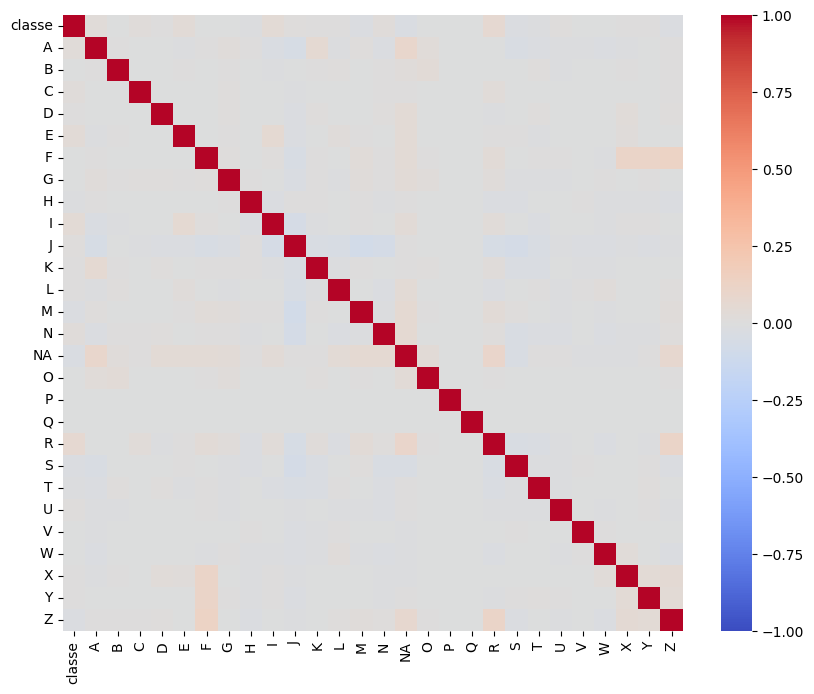

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    data[[c for c in data.columns if c != 'cod_usuario']].corr(), 
    annot=False, 
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1)

### Tratando dados para o modelo

Apenas determinando quais serão as variáveis explicadas (y) e as explicativas (X) do modelo.

In [11]:
# Define X e Y
X = data.drop(['classe', 'cod_usuario'], axis=1)
y = data['classe']


print('O formato da base de dados: ')
print(f'{X.shape=}\n{y.shape=}')

X.shape=(19834, 27)
y.shape=(19834,)


Desta forma, os dados serão divididos entre treino e teste, sendo 25% para testes.

In [12]:

X_train, X_test, \
y_train, y_test = train_test_split(X, 
                                   y, 
                                   test_size=0.25)



X_train.shape=(426, 27)
y_train.shape=(426,)
X_test.shape=(4959, 27)
y_test.shape=(4959,)


Como de praxe para modelagens de classificação, os dados serão padronizados em um intervalo utilizando sua média e desvio padrão. A média e desvio padrão utilizados para isto, serão as da base de dados de treino.

In [31]:
# Coleta os parametros da base de treinos
sts = StandardScaler()
sts.fit(X_train)

# Padroniza os dados
X_train = sts.transform(X_train)
X_test = sts.transform(X_test)


O desbalanceamento das classes ainda segue como um problema para a modelagem. 

Para isto, os dados com maior frequência serão aleatoriamente reduzidos de forma para transformá-los com a mesma quantidade de observações da classe minoritária.

In [ ]:

# Under sample os nao internados
rus = RandomUnderSampler(random_state=123)
X_train, y_train = rus.fit_resample(X_train, y_train)


print('Nova forma de dados: ')
print(f'{X_train.shape=}\n{y_train.shape=}')
print(f'{X_test.shape=}\n{y_test.shape=}')

### Model tunning

Com dados em mãos, é possível inciar a modelagem. Serão comparados os modelos de SVM e Redes Neurais.

Para otimizar os parâmetros (hyperparameter tunning) dos modelos, será utilizada a biblioteca `GridSearchCV`, que realiza iterações por todas as possíveis combinações de parâmetros selecionados.

#### SVM

Os parâmetros a serem alternados são os C, com trinta valores aleatórios, os kernels e seus graus.

In [14]:


svm_grid_parameters = {
    'C': [random() * (100 * random()) for _ in range(30)],
    'kernel': ['poly', 'rbf','sigmoid'], 
    'degree': [_ for _ in range(1, 5)], 
}

svm = SVC(random_state=123)

svm_grid = GridSearchCV(estimator = svm, 
                        param_grid = svm_grid_parameters, 
                        scoring='roc_auc'
                        )


svm_grid.fit(X_train, y_train)

# Para calcular medidas
best_svm_y_pred = svm_grid.best_estimator_.predict(X_test)

# Mostra as medidas
print()
print('Os melhores parâmetros:')
print(svm_grid.best_params_)

print()
print(classification_report(y_test, best_svm_y_pred))
print(f'MCC: {matthews_corrcoef(y_test, best_svm_y_pred)}')
print(f'ROC AUC: {roc_auc_score(y_test, best_svm_y_pred)}')



Os melhores parâmetros:
{'C': 29.463913016731794, 'degree': 1, 'kernel': 'poly'}

              precision    recall  f1-score   support

          -1       0.99      0.64      0.78      4874
           1       0.04      0.81      0.07        85

    accuracy                           0.64      4959
   macro avg       0.52      0.72      0.42      4959
weighted avg       0.98      0.64      0.76      4959

MCC: 0.11999944335459355
ROC AUC: 0.7234859639383042


#### Redes Neurais (NN)

Para as redes neurais, será utilizada uma arquitetura única:

- Camada de entrada
- Camada 01 com 32 neurônios e funções ReLu de ativação
- Camada 02 com 16 neurônios e funções ReLu de ativação
- Camada de saída, com um neurônio e função sigmoide

Porém, alternando o número de observações para estimação de cada época (`batch`) e o número de épocas, `epoch`.

In [15]:

# Factory de rede neural
def criar_rede_neural() -> Sequential:
    
    # Cria modelo
    model = Sequential()
    
    # Adiciona camada de input
    model.add(Input((27,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Cria rede neural
NN = KerasClassifier(model=criar_rede_neural, verbose=0)

# Parametros para otimizacao
NN_grid_parameters = {
    'batch_size': [32, 64],
    'epochs': [30, 50, 100],
}

# Gera a busca
NN_grid = GridSearchCV(estimator=NN, param_grid=NN_grid_parameters)
NN_grid.fit(X_train, y_train)

# Para calcular medidas
best_NN_y_pred = NN_grid.best_estimator_.predict(X_test)

# Mostra as medidas
print()
print('Os melhores parâmetros:')
print(NN_grid.best_params_)

print()
print(classification_report(y_test, best_NN_y_pred))
print(f'MCC: {matthews_corrcoef(y_test, best_NN_y_pred)}')
print(f'ROC AUC: {roc_auc_score(y_test, best_NN_y_pred)}')



Os melhores parâmetros:
{'batch_size': 64, 'epochs': 30}

              precision    recall  f1-score   support

          -1       0.99      0.60      0.75      4874
           1       0.03      0.74      0.06        85

    accuracy                           0.60      4959
   macro avg       0.51      0.67      0.40      4959
weighted avg       0.98      0.60      0.73      4959

MCC: 0.08960387794178436
ROC AUC: 0.6696239349248111


# Equivalência em R

Utilizando R, os tratamentos iniciais seriam realizados utilizando o pacote `dplyr`.

A segregação entre base de dados de treino e teste, por meio do método `sample`, nativo do R.

A normalização dos dados, utilizando o comando nativo `scale`.

O undersampling dos dados, utilizando o pacote `ROSE`, seria obtido pelo método `ROSE::ovun.sample`, passando o parâmetro `method="under"`.

O hypertunning dos parâmetros se daria pelo `expand.grid()` dos possíveis parâmetros e passado como `tuneGrid` nos comandos `train` para cada modelo.

A modelagem do SVM, pelo pacote `e1071`, com o método `e1071::svm()`.

A modelagem das redes neurais, seria realizada pelo pacote `keras`, que corresponde ao Keras do Python. 


## Considerações finais

É importante ressaltar que nenhum dos modelos foi muito eficiente para a tarefa. Talvez, a especificação do problema possa ser refinada, ou mesmo não faça sentido utilizar apenas as classes gerais dos CID para doenças. Também, um oversampling talvez melhore a performance dos modelos, mas não possuo capacidade computacional para isto.
